## PepperDetection


In [1]:

import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/sharvarisoparkar/Desktop/MiniProject/PepperDetection',
    seed=10,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3901 files belonging to 2 classes.


In [4]:

class_names =dataset.class_names
class_names

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0]


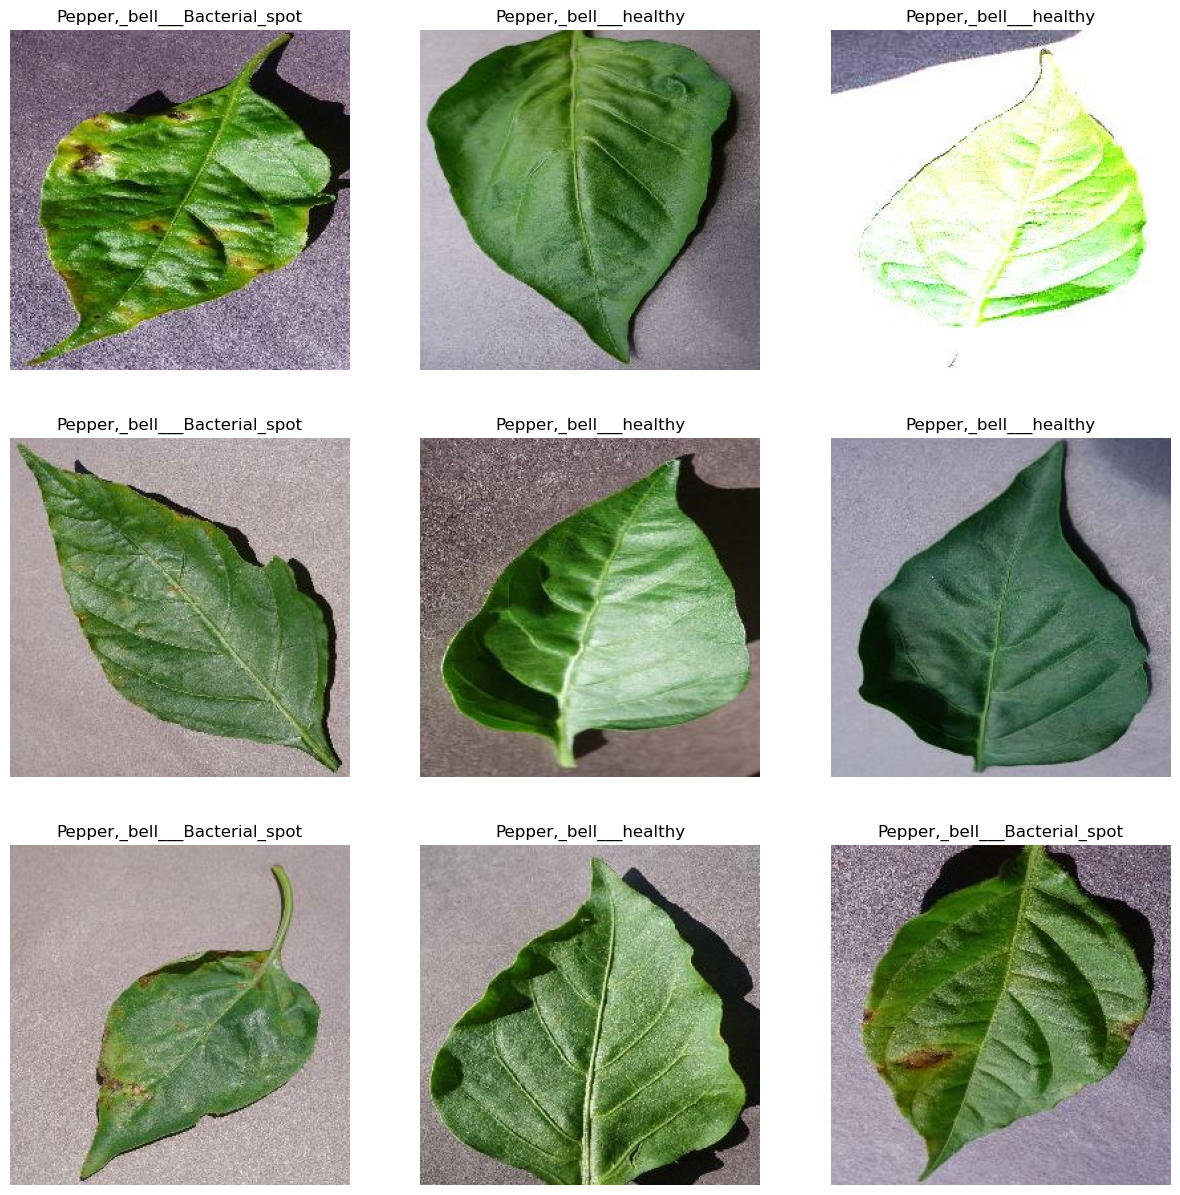

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

122

In [8]:
train_size = 0.8
len(dataset)*train_size

97.60000000000001

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

68

In [10]:
val_size=0.1
len(dataset)*val_size

12.200000000000001

In [11]:

val_ds = test_ds.take(6)
len(val_ds)


6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

62

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:


history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)


Epoch 1/5
97/97 [==============================] - 145s 1s/step - loss: 0.5315 - accuracy: 0.7294 - val_loss: 0.2370 - val_accuracy: 0.9036
Epoch 2/5
97/97 [==============================] - 394s 4s/step - loss: 0.1818 - accuracy: 0.9340 - val_loss: 0.1162 - val_accuracy: 0.9557
Epoch 3/5
97/97 [==============================] - 133s 1s/step - loss: 0.1301 - accuracy: 0.9572 - val_loss: 0.1610 - val_accuracy: 0.9271
Epoch 4/5
97/97 [==============================] - 199s 2s/step - loss: 0.0952 - accuracy: 0.9704 - val_loss: 0.0538 - val_accuracy: 0.9792
Epoch 5/5
97/97 [==============================] - 128s 1s/step - loss: 0.0650 - accuracy: 0.9784 - val_loss: 0.1149 - val_accuracy: 0.9661


In [24]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 6s 328ms/step - loss: 0.1201 - accuracy: 0.9661


In [25]:
scores

[0.12011759728193283, 0.9661017060279846]

first image to predict
actual label: Pepper,_bell___Bacterial_spot
1/1 [==============================] - 0s 393ms/step
predicted label: Pepper,_bell___Bacterial_spot


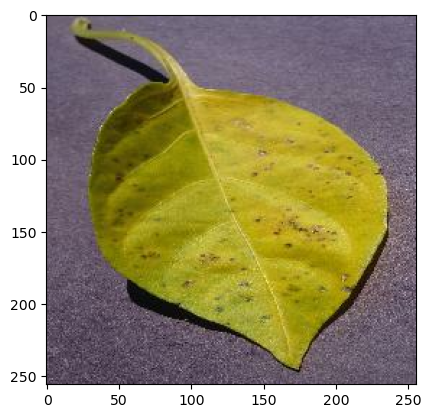

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [33]:
predict(model, '/Users/sharvarisoparkar/Desktop/MiniProject/PepperDetection/Pepper,_bell___Bacterial_spot/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG')


1/1 [==============================] - 0s 31ms/step


('Pepper,_bell___Bacterial_spot', 99.96)

1/1 [==============================] - 0s 24ms/step


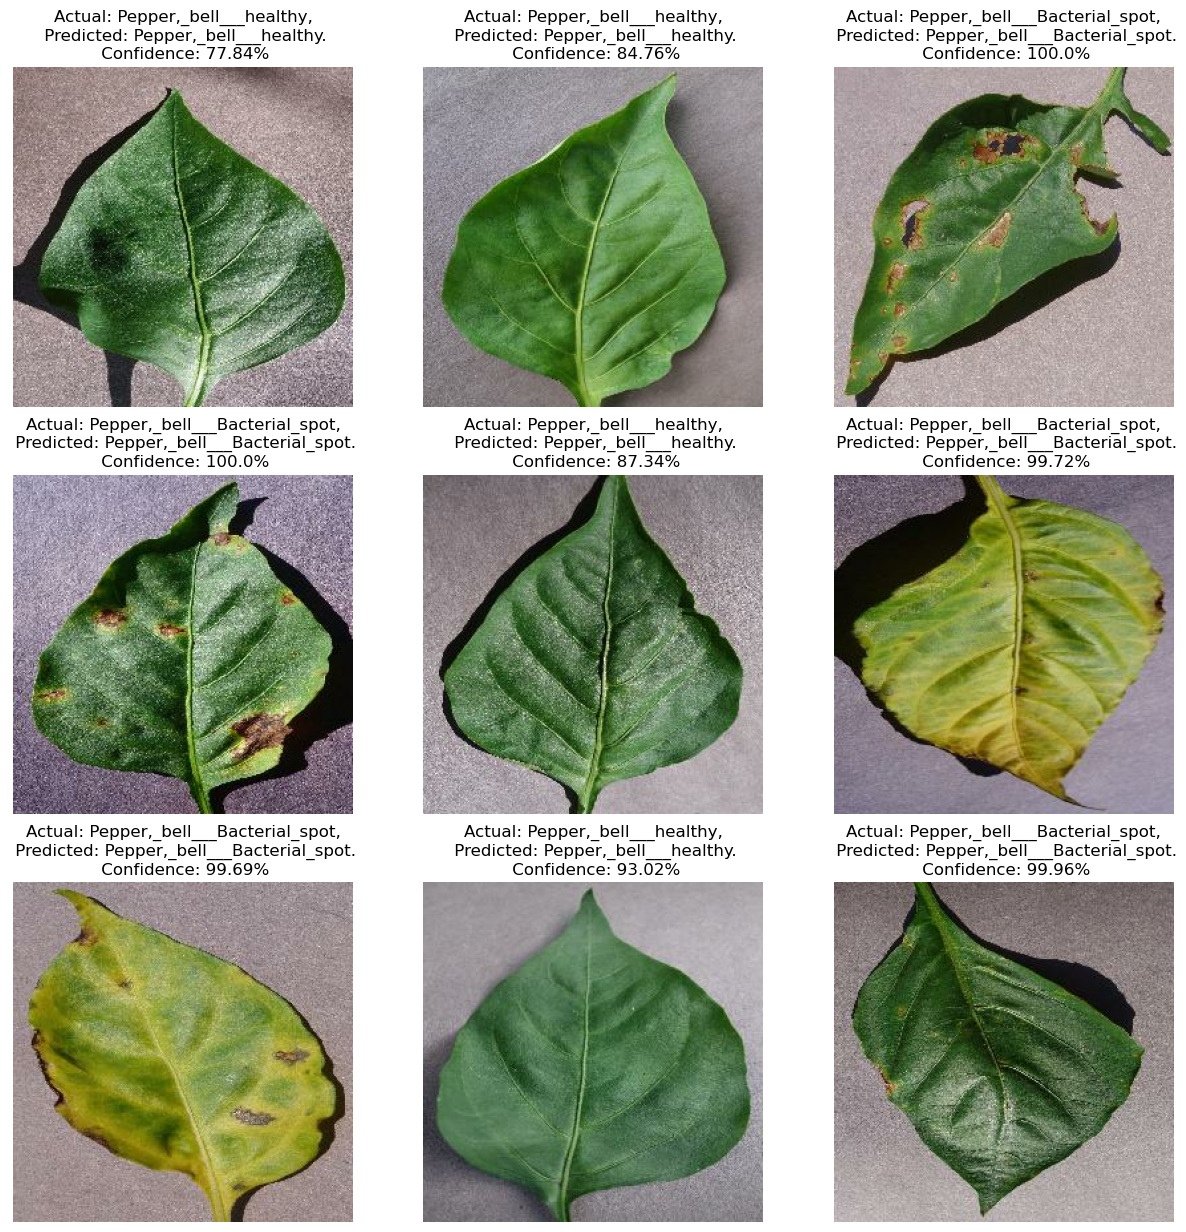

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [34]:
model_version= 3
model.save(f'/Users/sharvarisoparkar/Desktop/MiniProject/Models/{model_version}')

INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/3/assets


INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/3/assets
